In [0]:
# Реализовать и обучить (с нуля) СНС для задачи классификации изображений на датасете CIFAR-10

In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
X_train = X_train.reshape(-1, 32, 32, 3).astype(np.float32) / 255.
X_test = X_test.reshape(-1, 32, 32, 3).astype(np.float32) / 255.

y_train = y_train.reshape(-1,).astype(np.int32)
y_test = y_test.reshape(-1,).astype(np.int32)

In [0]:
NUM_EPOCHS = 5
BATCH_SIZE = 128

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=X_train.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [0]:
def loss(logits, labels):
  return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,
                                                                       labels=labels))

def accuracy(logits, labels):
  predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
  return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

In [0]:
class Model(tf.keras.Model):

  def __init__(self):
    super(Model, self).__init__()

    self.conv2d_1 = layers.Conv2D(32, (5, 5), activation='relu',
                                  padding="same")
    
    self.avgpool2d_1 = layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2),
                                               padding='valid')
    
    self.conv2d_2 = layers.Conv2D(64, (5, 5), activation='relu',
                                  padding='same')
    
    self.avgpool2d_2 = layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2),
                                               padding='same')
    
    self.convd2d_3 = layers.Conv2D(64, (5, 5), activation='relu',
                                   padding='same')
    
    self.maxpool2d_1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
                                           padding='same')
    
    self.conv2d_4 = layers.Conv2D(128, (5, 5), activation='relu',
                                  padding='same')
    
    self.flat = layers.Flatten()

    self.dense_1 = layers.Dense(256, activation='relu')
    self.dense_2 = layers.Dense(10, activation='softmax')
  
  def call(self, inp):
    out = self.conv2d_1(inp)
    out = self.avgpool2d_1(out)
    out = self.conv2d_2(out)
    out = self.avgpool2d_2(out)
    out = self.convd2d_3(out)
    out = self.maxpool2d_1(out)
    out = self.conv2d_4(out)
    out = self.flat(out)
    out = self.dense_1(out)
    out = self.dense_2(out)
    return out

In [0]:
model = Model()

In [0]:
LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
writer = tf.summary.create_file_writer('logs/adam')

model = Model()

In [42]:
%%time

for iteration, (images, labels) in enumerate(train_ds):

  # Forward
  with tf.GradientTape() as tape:
    logits = model(images)
    loss_value = loss(logits, labels)

  # Backward
  grads = tape.gradient(loss_value, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  

  if iteration % 50 == 0:
    test_logits = model(X_train[:256, ...])
    accuracy_value = accuracy(test_logits, y_train[:256, ...])

    print(f'[{iteration:>6}] Accuracy: {accuracy_value.numpy()*100:>5.2f} %')

    with writer.as_default():
      tf.summary.scalar('accuracy', accuracy_value, iteration)
      tf.summary.scalar('loss', loss_value, iteration)

[     0] Accuracy:  7.03 %
[    50] Accuracy: 20.31 %
[   100] Accuracy: 32.42 %
[   150] Accuracy: 34.77 %
[   200] Accuracy: 34.77 %
[   250] Accuracy: 35.94 %
[   300] Accuracy: 41.80 %
[   350] Accuracy: 41.41 %
[   400] Accuracy: 43.36 %
[   450] Accuracy: 45.70 %
[   500] Accuracy: 36.72 %
[   550] Accuracy: 46.09 %
[   600] Accuracy: 47.27 %
[   650] Accuracy: 46.88 %
[   700] Accuracy: 48.44 %
[   750] Accuracy: 48.05 %
[   800] Accuracy: 49.22 %
[   850] Accuracy: 54.69 %
[   900] Accuracy: 48.44 %
[   950] Accuracy: 53.91 %
[  1000] Accuracy: 49.22 %
[  1050] Accuracy: 55.86 %
[  1100] Accuracy: 49.61 %
[  1150] Accuracy: 51.56 %
[  1200] Accuracy: 54.69 %
[  1250] Accuracy: 55.47 %
[  1300] Accuracy: 52.73 %
[  1350] Accuracy: 55.08 %
[  1400] Accuracy: 53.91 %
[  1450] Accuracy: 59.38 %
[  1500] Accuracy: 57.03 %
[  1550] Accuracy: 59.77 %
[  1600] Accuracy: 59.77 %
[  1650] Accuracy: 59.38 %
[  1700] Accuracy: 60.55 %
[  1750] Accuracy: 57.42 %
[  1800] Accuracy: 60.55 %
[

In [0]:
def test_image(sample):
  logits = model(sample[None, ...])[0]
  prediction = tf.nn.softmax(logits)
  ans = np.argmax(prediction)

  fig = plt.figure(figsize=(12,4))

  ax = fig.add_subplot(1,2,1)
  ax.imshow(sample)
  plt.xticks([]), plt.yticks([])

  ax = fig.add_subplot(1,2,2)
  bar_list = ax.bar(np.arange(10), prediction, align='center')
  bar_list[ans].set_color('g')
  ax.grid(True)

  plt.show()

Classes: <br>
1. airplance
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck

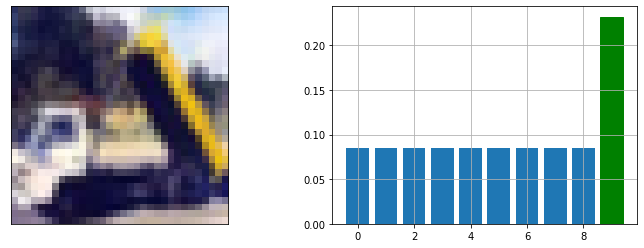

In [68]:
idx = random.randint(0, X_test.shape[0])
sample = X_test[idx, ...]
test_image(sample)